<a href="https://colab.research.google.com/github/timothyow/Agents/blob/main/Report_writing_agent_MapReduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Map-reduce operations are used for task decomposition and parallel processing.

It has two components:

1. Map - Break a task into sub-tasks and process each sub-task in parallel.

2. Reduce - Aggregate the results of all completed, parallelized sub-tasks.


LangGraph has a Send function to enable this Map Reduce operation.

- Task Decomposition: Breaks down a complex task into smaller, manageable sub-tasks (planning or complex question decomposition)
- Parallel Processing: Executes sub-tasks in parallel, reducing overall processing time.
- Result Aggregation: Combines results of all sub-tasks to form a comprehensive response.





## Install OpenAI, LangGraph and LangChain dependencies

In [1]:
!pip install langchain==0.3.14
!pip install langchain-openai==0.3.0
!pip install langchain-community==0.3.14
!pip install langgraph==0.2.64

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 628.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.9/326.9 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 17.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.3.42
    Uninstalling langsmith-0.3.42:
      Successfully uninstalled langsmith-0.3.42
  Attempting uninstall: langchain
    Found existing installation: langchain 0.3.25
    Uninstalling langchain-0.3.25:
      Successfully uninstalled langchain-0.3.25
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<

## Enter Open AI API Key

In [2]:
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

Enter Open AI API Key: ··········


## Setup Environment Variables

In [3]:
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY

## Define Agent State Schema

In [4]:
from typing_extensions import TypedDict
from pydantic import BaseModel
import operator
from typing import Annotated

# Define state
class Questions(BaseModel):
    questions: list[str]

class Answer(BaseModel):
    question: str
    answer: str

class Report(BaseModel):
    report: str

class OverallState(TypedDict):
    topic: str
    questions: list
    answers: Annotated[list, operator.add]
    report: str

## Role of the Send Function
Dynamic Distribution: Dispatches varying state payloads to multiple node instances for parallel execution.

Adaptive Workflows: Useful when the number of parallel tasks isn't fixed—e.g., generating a random number of questions or steps and processing each in parallel.

In [23]:
from langgraph.constants import Send
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", temperature=0)

# Node to generate questions
def generate_questions(state: OverallState):
    questions_prompt = questions_prompt = f"""
      You are helping to build a report. Generate a list of concise sub-questions that would help explore the topic: "{state['topic']}".

      Follow these instructions:
      1. Keep each question short, focused, and relevant to the topic.
      2. First, decide if the topic is SIMPLE or COMPLEX based on its specificity:
        - SIMPLE topics are broad or introductory (e.g., "What is AI?", "Benefits of exercise", "History of birds")
        - COMPLEX topics are analytical or require deeper breakdown (e.g., "How to improve sales using AI?", "Impact of AI on customer behavior", "Strategies to optimize GTM")
      3. If the topic is SIMPLE, generate exactly 3 questions.
        If the topic is COMPLEX, generate exactly 5 questions.
      4. Do NOT explain your reasoning — only output the list of questions.
      """.strip()

    prompt = questions_prompt.format(topic=state["topic"])
    response = llm.with_structured_output(Questions).invoke(prompt)
    return {"questions": response.questions}

# Node to generate answer to one question
def generate_answer(state: Answer):
    answer_prompt = """Generate the answer about {question}."""
    prompt = f"Generate the answer about {state['question']}."
    response = llm.with_structured_output(Answer).invoke(prompt)
    return {"answers": [{"question": state["question"], "answer": response.answer}]}

# Node to continue to answers
def continue_to_answers(state: OverallState):
    questions = state.get("questions", [])
    return [Send("generate_answer", {"question": q}) for q in questions] #parallel questions


# Node to compile the report
def compile_report(state: OverallState):
    q_and_a = "\n\n".join(
        [f"Q: {qa['question']}\nA: {qa['answer']}" for qa in state["answers"]]
    )
    report_prompt = """
        Below are a set of questions and answers about the topic: {topic}.

        Generate a clear and informative report summarizing the main points.
        - Keep the report under 300 words.
        - Use concise language.
        - Avoid repeating the original Q&A.
        - Do not exceed 5 paragraphs.

        Q&A:
        {q_and_a}
        """.strip()

    prompt = report_prompt.format(topic=state["topic"], q_and_a=q_and_a)
    response = llm.with_structured_output(Report).invoke(prompt)
    return {"report": response.report}



## Create Agent

In [24]:
from langgraph.graph import StateGraph, START, END

# Compile the graph
graph = StateGraph(OverallState)
graph.add_node("generate_questions", generate_questions)
graph.add_node("generate_answer", generate_answer)
graph.add_node("compile_report", compile_report)

graph.add_edge(START, "generate_questions")
graph.add_conditional_edges("generate_questions",
                            continue_to_answers,
                            ["generate_answer"])
graph.add_edge("generate_answer", "compile_report")
graph.add_edge("compile_report", END)

# Compile the app
agent = graph.compile()

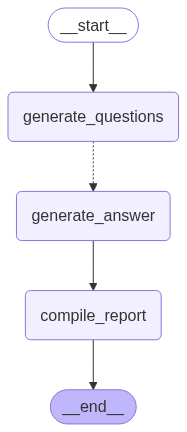

In [7]:
# Display the graph
from IPython.display import display, Image
Image(agent.get_graph().draw_mermaid_png())

## Run and Test the Agent

In [25]:
from IPython.display import display, Markdown

for state in agent.stream({"topic": "AI Agents"}):
    print(state)
    if 'compile_report' in state:
        display(Markdown(state['compile_report']['report']))

{'generate_questions': {'questions': ['What are AI agents?', 'How do AI agents function?', 'What are the different types of AI agents?', 'What are the primary applications of AI agents?', 'How do AI agents impact decision-making processes?']}}
{'generate_answer': {'answers': [{'question': 'What are the primary applications of AI agents?', 'answer': 'AI agents are versatile tools that can be applied across various domains to enhance efficiency, decision-making, and user experience. Here are some of the primary applications of AI agents:\n\n1. **Customer Service and Support:**\n   - **Chatbots:** AI agents can handle customer inquiries, provide information, and resolve issues through text or voice interactions.\n   - **Virtual Assistants:** These agents help users manage tasks, schedule appointments, and provide reminders.\n\n2. **Healthcare:**\n   - **Diagnostic Tools:** AI agents assist in analyzing medical images, predicting patient outcomes, and suggesting treatment plans.\n   - **Pa

### Overview of AI Agents
AI agents are autonomous or semi-autonomous software entities designed to perform tasks on behalf of users or other programs. They perceive their environment, make decisions, and take actions to achieve specific goals. These agents range from simple rule-based systems to complex models utilizing machine learning and deep learning techniques.

### Characteristics and Functionality
AI agents are characterized by their autonomy, perception, decision-making, action, and adaptability. They operate independently, gather information through sensors or data inputs, process this information using algorithms, and execute actions to meet their objectives. Many AI agents can learn from experiences, adapting their behavior to improve performance over time.

### Types of AI Agents
AI agents can be categorized into several types based on their capabilities:
- **Reactive Agents** respond to environmental changes without maintaining an internal state.
- **Deliberative Agents** use an internal model to plan actions and make complex decisions.
- **Hybrid Agents** combine reactive and deliberative features for quick responses and future planning.
- **Learning Agents** improve performance by learning from experiences and adapting to new situations.

### Applications Across Industries
AI agents are applied in various domains, enhancing efficiency and decision-making:
- **Virtual Assistants** like Siri and Alexa help users perform tasks via voice commands.
- **Autonomous Vehicles** use AI agents for navigation and safety.
- **Robotics** employs AI for tasks in manufacturing and healthcare.
- **Financial Trading** utilizes AI for market analysis and trade execution.

### Impact on Decision-Making
AI agents transform decision-making by providing data-driven insights, improving accuracy, and enabling real-time responses. They automate routine decisions, reduce errors, and offer personalized recommendations. AI agents also assist in risk management and strategic planning, ensuring informed and efficient decision-making processes.

In conclusion, AI agents are pivotal in advancing technology, performing complex tasks efficiently, and often surpassing human capabilities in specific domains. Their continuous evolution and application across industries highlight their indispensable role in the modern world.

In [13]:
for state in agent.stream({"topic": "What is Zatar?"}):
    print(state)
    if 'compile_report' in state:
        display(Markdown(state['compile_report']['report']))

{'generate_questions': {'questions': ['What are the main ingredients of Zatar?', 'How is Zatar traditionally used in cooking?', 'What are the health benefits of consuming Zatar?', 'How does Zatar vary across different cultures or regions?', 'What are some popular dishes that feature Zatar?']}}
{'generate_answer': {'answers': [{'question': 'What are the main ingredients of Zatar?', 'answer': "Zatar, also spelled Za'atar, is a traditional Middle Eastern spice blend that is both aromatic and flavorful. It is commonly used in various dishes to add a unique taste and aroma. The main ingredients of Zatar typically include:\n\n1. **Thyme**: \n   - Often the primary herb in Zatar, thyme provides a warm, earthy flavor.\n\n2. **Sumac**: \n   - This reddish-purple spice adds a tangy, lemony taste to the blend.\n\n3. **Sesame Seeds**: \n   - Toasted sesame seeds contribute a nutty flavor and crunchy texture.\n\n4. **Salt**: \n   - Enhances the overall flavor profile of the blend.\n\n5. **Oregano**

### Detailed Report on Zatar

**Introduction**
Zatar, also spelled Za'atar, is a traditional Middle Eastern spice blend renowned for its aromatic and flavorful profile. It is a staple in Middle Eastern cuisine, celebrated for its versatility and the unique taste it imparts to various dishes. This report delves into the composition, culinary uses, health benefits, regional variations, and popular dishes featuring Zatar.

---

**Composition of Zatar**
Zatar is a harmonious blend of several key ingredients, each contributing to its distinctive flavor:

1. **Thyme**: The primary herb, offering a warm, earthy flavor.
2. **Sumac**: Adds a tangy, lemony taste with its reddish-purple hue.
3. **Sesame Seeds**: Provide a nutty flavor and crunchy texture.
4. **Salt**: Enhances the overall flavor profile.
5. **Oregano**: Occasionally included for an additional herbal note.
6. **Marjoram**: Sometimes added for its sweet, citrusy flavor.

**Variations**: The proportions and additional ingredients can vary by region, leading to subtle differences in taste and aroma.

---

**Culinary Uses of Zatar**
Zatar's versatility makes it a beloved ingredient in various culinary applications:

1. **Seasoning for Bread**: Used as a topping for flatbreads like manakish, brushed with olive oil and baked.
2. **Marinades and Rubs**: Enhances the flavor of meats, poultry, and grilled vegetables.
3. **Condiment**: Mixed with olive oil for dipping or sprinkled over dishes like hummus and labneh.
4. **Salads**: Incorporated into dressings or used to season grain-based salads.
5. **Baking**: Used in savory pastries for a burst of flavor.
6. **Soups and Stews**: Adds depth to the flavor profile.
7. **Snacks**: Roasted nuts or popcorn with Zatar offer a unique twist.

---

**Health Benefits of Zatar**
Zatar is not only flavorful but also offers several health benefits:

1. **Rich in Antioxidants**: Contains herbs like thyme and sumac, which combat oxidative stress.
2. **Anti-inflammatory Properties**: Helps reduce inflammation in the body.
3. **Supports Digestive Health**: Sesame seeds provide fiber, aiding digestion.
4. **Boosts Immune System**: Rich in vitamins C and A, essential for immunity.
5. **Improves Heart Health**: Sesame seeds contribute to healthy cholesterol levels.
6. **Enhances Cognitive Function**: May improve memory and concentration.
7. **Antimicrobial Effects**: Protects against bacterial and fungal infections.
8. **Bone Health**: Sesame seeds are rich in calcium and magnesium.
9. **Mood Enhancement**: The aroma and flavor can reduce stress.

---

**Regional Variations of Zatar**
Zatar's composition varies across different cultures and regions:

1. **Levantine Region**: Traditional blend with thyme, sumac, sesame seeds, and salt.
2. **Israeli Zatar**: Similar to Levantine, with possible additions like oregano.
3. **Egyptian Dukkah**: A related blend with nuts and spices.
4. **Turkish Zatar**: May include cumin or fennel seeds.
5. **North African Zatar**: Complex with coriander or caraway seeds.
6. **Gulf Region**: May include dried lime or saffron.

---

**Popular Dishes Featuring Zatar**
Zatar enhances a variety of dishes, both traditional and modern:

1. **Zatar Manakish**: Flatbread with Zatar and olive oil.
2. **Zatar Roasted Chicken**: Marinated and roasted chicken.
3. **Zatar Hummus**: Classic hummus with Zatar topping.
4. **Zatar Grilled Vegetables**: Tossed and grilled vegetables.
5. **Zatar Labneh**: Creamy labneh with Zatar.
6. **Zatar Crusted Fish**: Fish fillets with a Zatar crust.
7. **Zatar Pizza**: Modern twist with Zatar topping.
8. **Zatar Popcorn**: Savory snack with Zatar.
9. **Zatar Roasted Potatoes**: Crispy roasted potatoes.
10. **Zatar Salad**: Fresh salad with Zatar dressing.

---

**Conclusion**
Zatar's rich flavors and health benefits make it a cherished ingredient in Middle Eastern cuisine. Its adaptability across different regions and dishes highlights its cultural significance and culinary versatility. Whether used as a seasoning, condiment, or flavor enhancer, Zatar continues to captivate palates worldwide, offering a taste of the exotic in everyday meals.

#Launch it on Gradio

In [19]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.6 MB/s eta 0:00:00


In [26]:
def interact_with_agent(topic: str):
    state = {"topic": topic}
    final_state = agent.invoke(state)
    return final_state["report"]

In [29]:
import gradio as gr

demo = gr.Interface(fn=interact_with_agent,
                    inputs=gr.Textbox(lines=2, placeholder="Enter a topic..."),
                    outputs="text",
                    title="Report Writing Agent Demo",
                    description="Enter a topic to generate a structured report via AI agents.")

demo.launch(share=True)  # share=True gives a public link


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://504e4ce28141d9f3a5.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
